In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data

Load data as `msgpack`

In [2]:
data = pd.read_msgpack("data_2018-10-10-18-15-06.msgpack")
df = pd.DataFrame.from_dict(data)
df.head()

,F,MDia,Msgtype,PWM,Rc,Rw,T,T0,TimeStamp
0,-1.924732,1.0,2,0,29.1,0.4,29.597118,26.686825,36.826424
1,-1.903733,1.0,2,0,29.1,0.4,29.597118,26.686825,36.840061
2,-1.318297,1.0,2,0,29.1,0.4,29.596083,26.689442,36.850365
3,-0.999092,1.0,2,0,29.1,0.4,29.596083,26.689442,36.869370
4,-2.489463,1.0,2,0,29.1,0.4,29.599459,26.689442,36.888580


In [3]:
df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
df.head()
if(df.iloc[0].timestamp > 0):
    df.timestamp -= df.iloc[0].timestamp

Clean $ F_t < F_{min} $ (OPTIONAL)

In [4]:
#df.drop(df[df.f < 0].index, inplace=True)

Replace PWM$=0$ with PWM$=NaN$

In [5]:
df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)

## Graphs

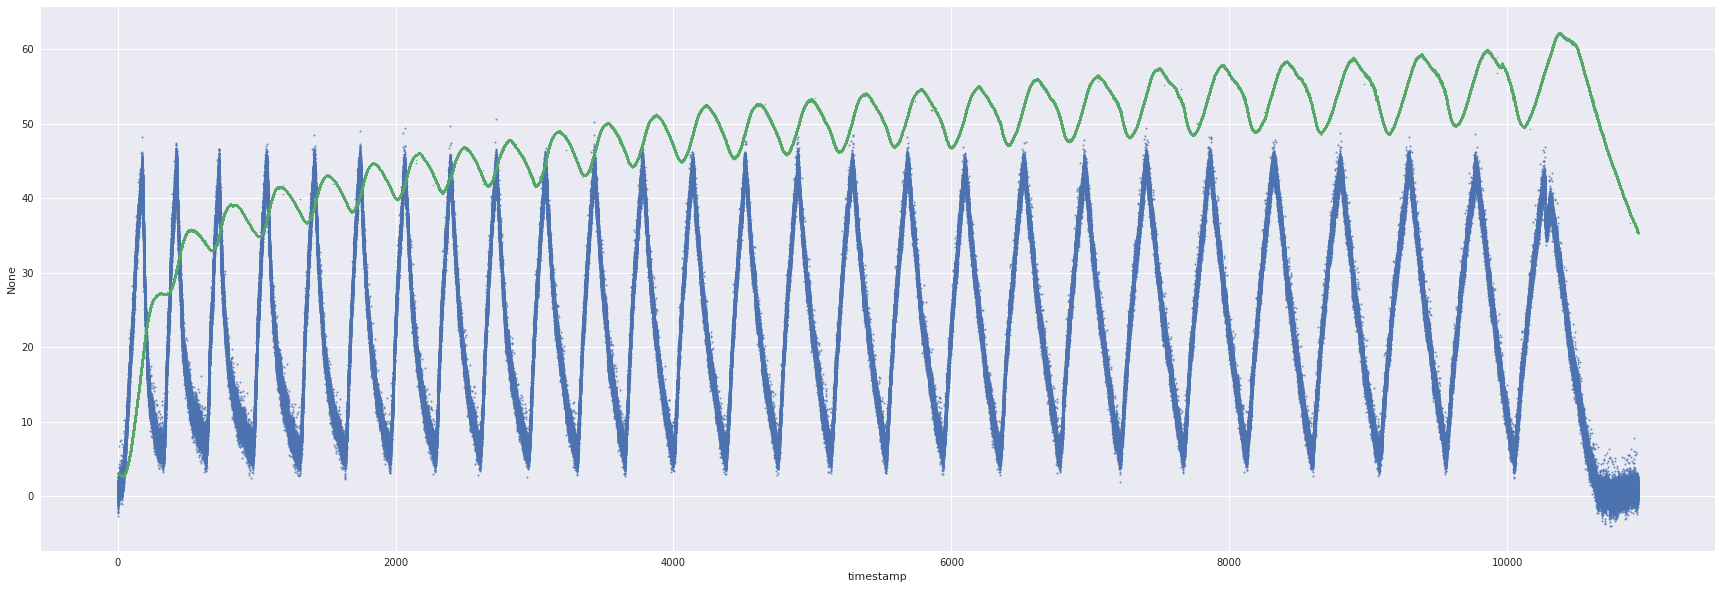

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
sns.regplot(df.timestamp, -df.f, fit_reg=False, scatter_kws={"s": 4})
sns.regplot(df.timestamp, df.t-df.t0, fit_reg=False, scatter_kws={"s": 2})

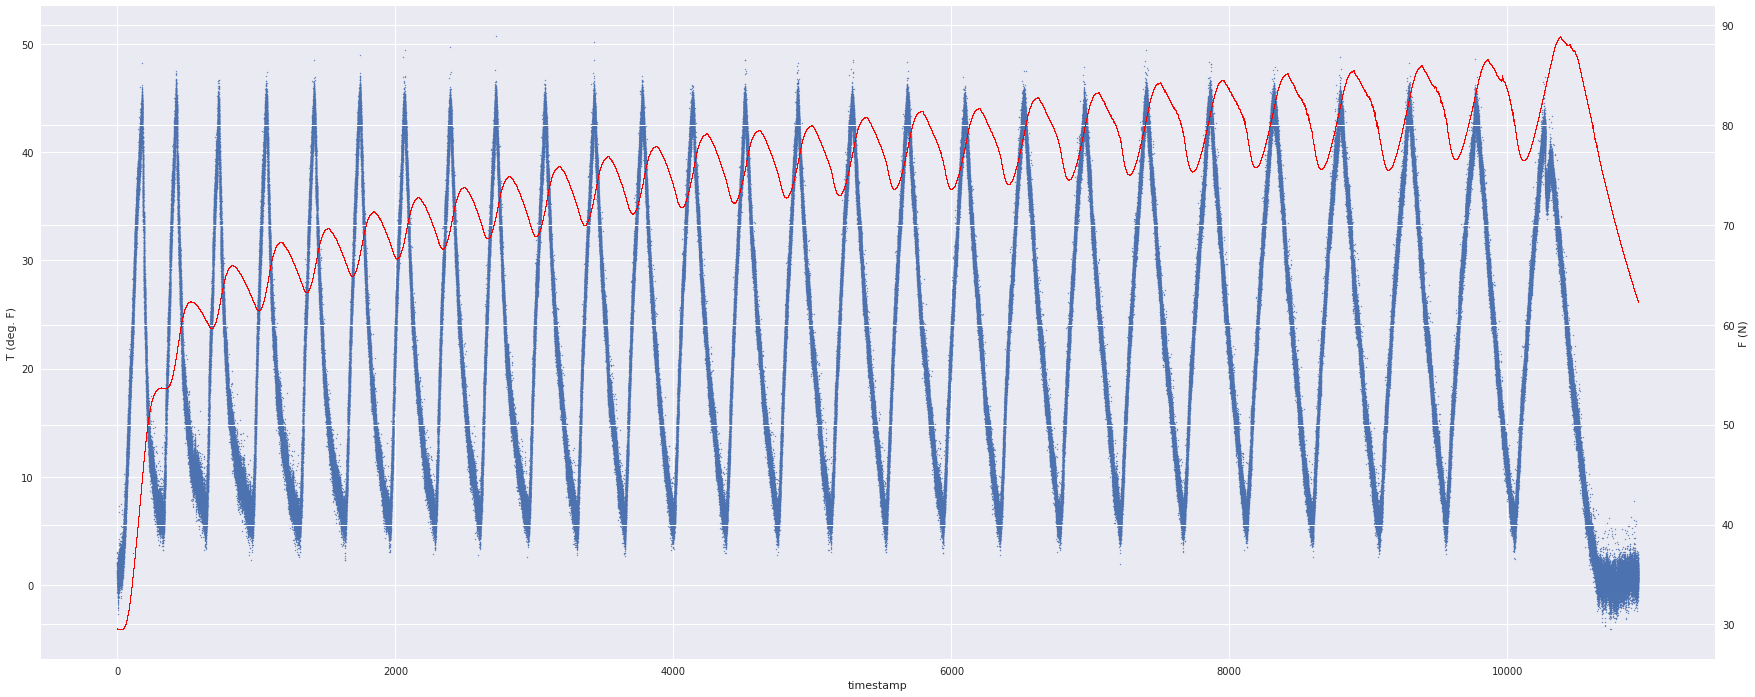

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(30,12))
sns.regplot(df.timestamp, -df.f, ax=ax, fit_reg=False, scatter_kws={"s": 2})
ax2 = ax.twinx()
sns.regplot(df.timestamp, df.t, ax=ax2, fit_reg=False, scatter_kws={"s": 1, "color": "red"})

ax.set_ylabel('T (deg. F)')
ax2.set_ylabel('F (N)');  # relative to plt.rcParams['font.size']

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

$$ R^2 = 1 - \frac{\textrm{sum of squared residuals}}{n\times\sigma^2} $$
$$ \in (-\infty, 1] $$

### Moving averages (smoothing)
$$ \hat{y_t} = \frac{1}{k}\sum_{1}^k y_{t-n} $$

In [11]:
ma = lambda s, n: np.average(s[-n:])

In [12]:
def plot_ma(s, win, ax, alpha=1.0, plot_intervals=False, scale=1, get_ma=False):
    ma = s.rolling(window=win).mean()
    if plot_intervals:
        mae = mean_absolute_error(s[win:], ma[win:])
        std = np.std(s[win:] - ma[win:])
        lower = ma - (mae+scale*std)
        upper = ma + (mae+scale*std)
        ax.plot(lower, "r--", alpha=alpha)
        ax.plot(upper, "r--", alpha=alpha)
    ax.plot(ma, alpha=alpha)
    if get_ma:
        return ma

In [10]:
df.head()

,f,mdia,msgtype,pwm,rc,rw,t,t0,timestamp
0,-1.924732,1.0,2,NaN,29.1,0.4,29.597118,26.686825,0.000000
1,-1.903733,1.0,2,NaN,29.1,0.4,29.597118,26.686825,0.013638
2,-1.318297,1.0,2,NaN,29.1,0.4,29.596083,26.689442,0.023941
3,-0.999092,1.0,2,NaN,29.1,0.4,29.596083,26.689442,0.042946
4,-2.489463,1.0,2,NaN,29.1,0.4,29.599459,26.689442,0.062157


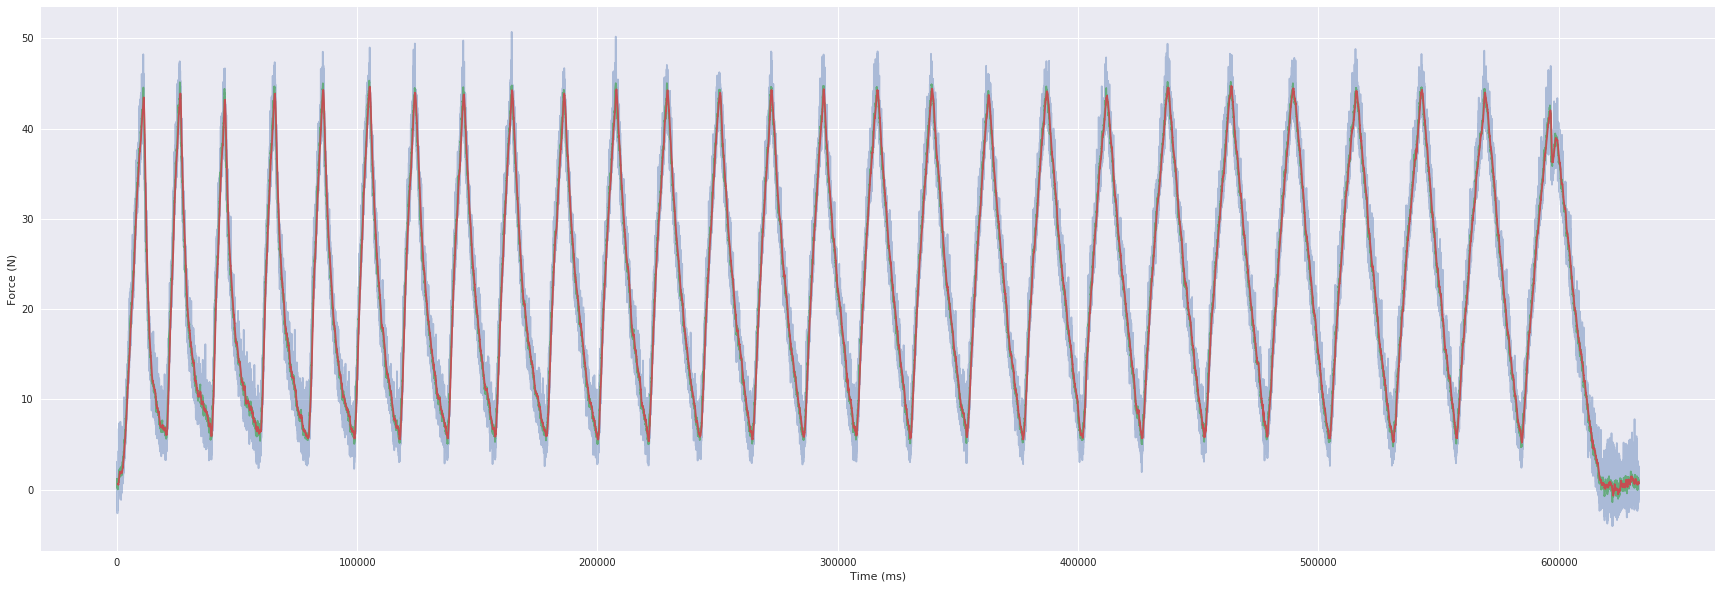

In [11]:
K_ALPHA = 0.4
fig, axes = plt.subplots(1, 1, figsize=(30,10))
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
for i, win in enumerate([1, 100, 500]):
    plot_ma(-df.f, int(win), axes, min(K_ALPHA*(i+1), 1))

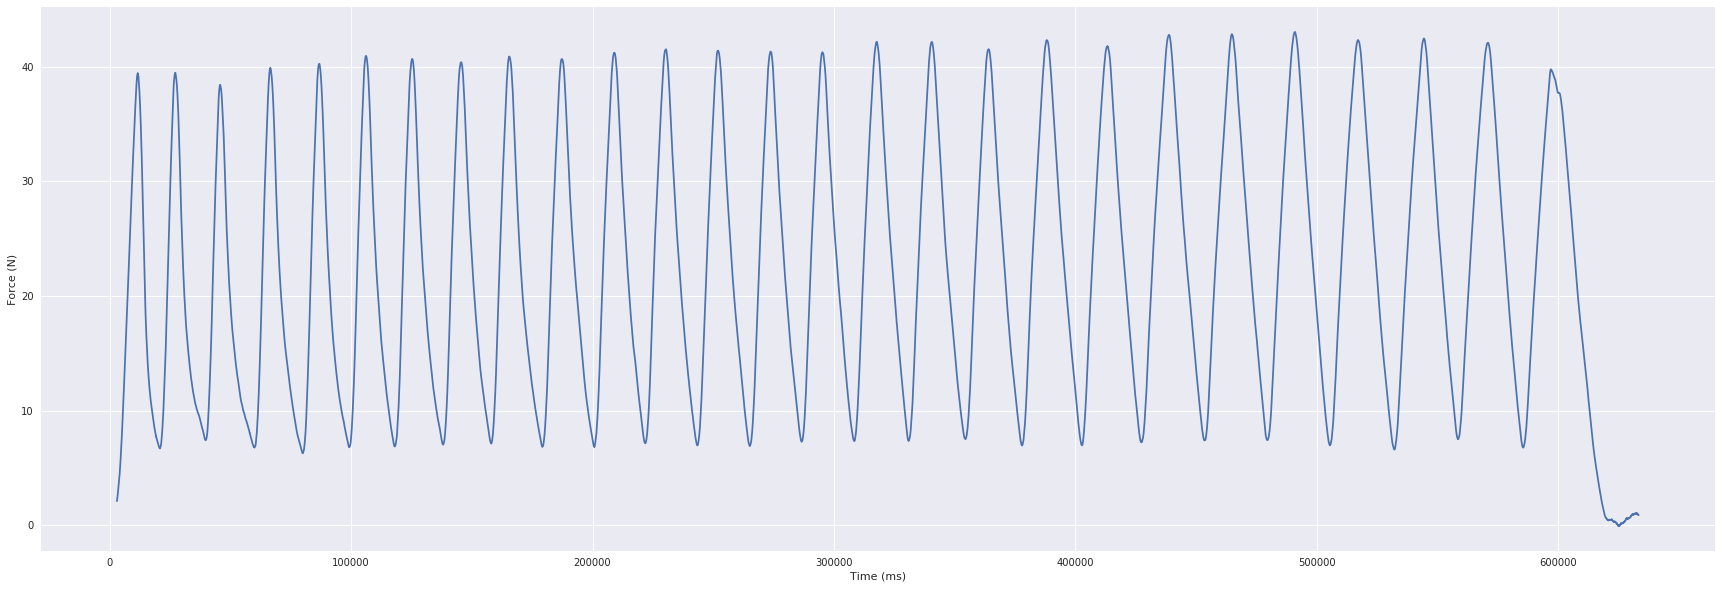

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
plot_ma(-df.f, 3000, ax, 1)

### with MAE confidence intervals
$$ \frac{\sum_{i=1}^n \vert y_i - \hat{y_i} \vert}{n} $$

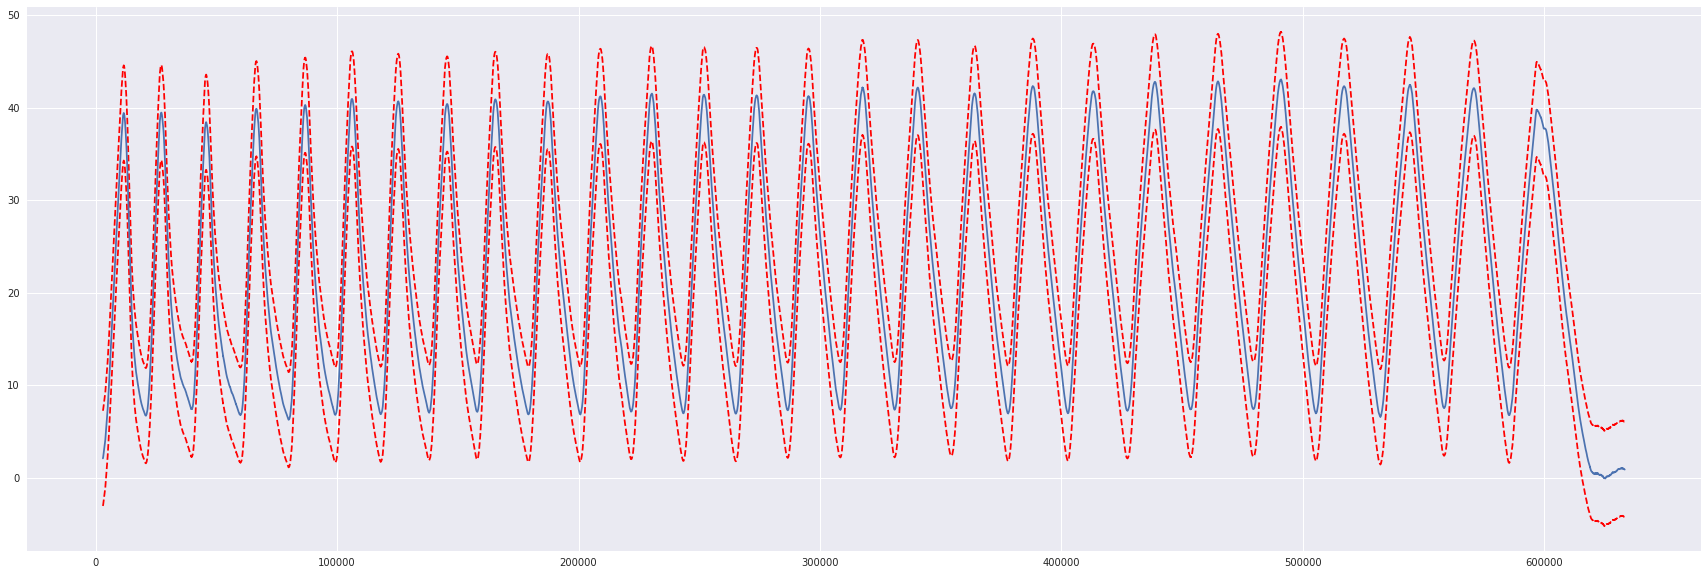

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
plot_ma(-df.f, 3000, ax, 1, plot_intervals=True, scale=0.1)

# Detrend temperature

In [12]:
from statsmodels.tsa.tsatools import detrend

In [13]:
X = df.t
X = detrend(X, order=0, axis=0)

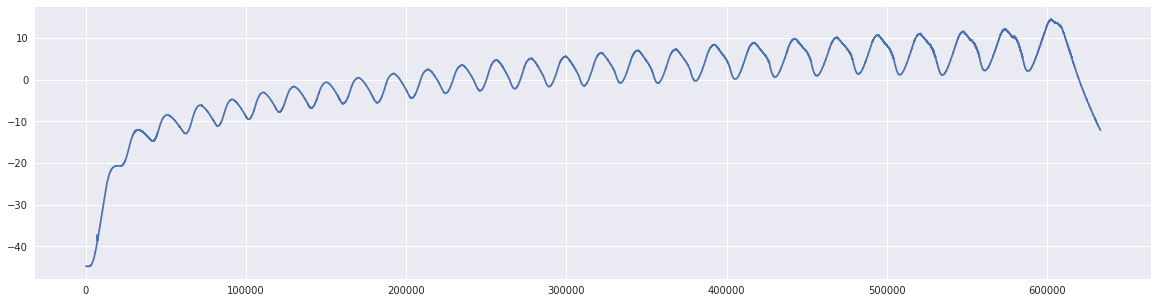

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(X)

In [14]:
from scipy.optimize import curve_fit

In [15]:
temp = df.iloc[10000:,:]
temp.timestamp -= temp.timestamp.iloc[0]
temp.reset_index(drop=True);

/home/nwchen/.local/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [16]:
y, X = temp.t, temp.timestamp
def func(x, a, b, c): 
    return a * np.exp(-b*x) + c

### Fit temperature trend (est. $log\,n$)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


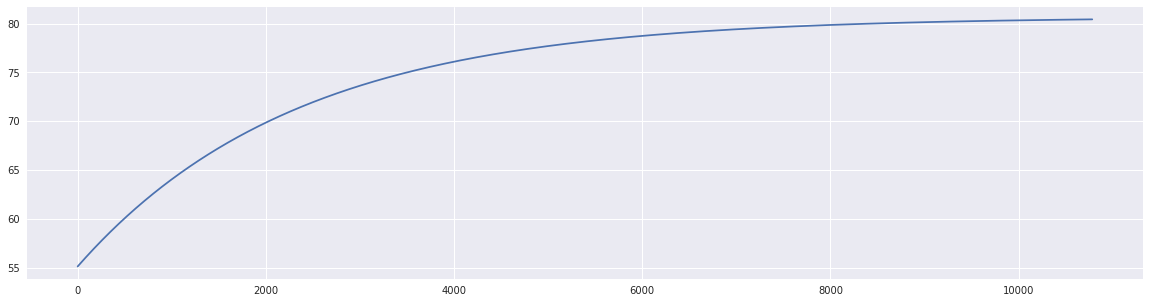

In [17]:
pt, pcov = curve_fit(func, X, y)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(X, func(X, *pt))

__GREEN__: Raw,
__BLUE__: Detrended

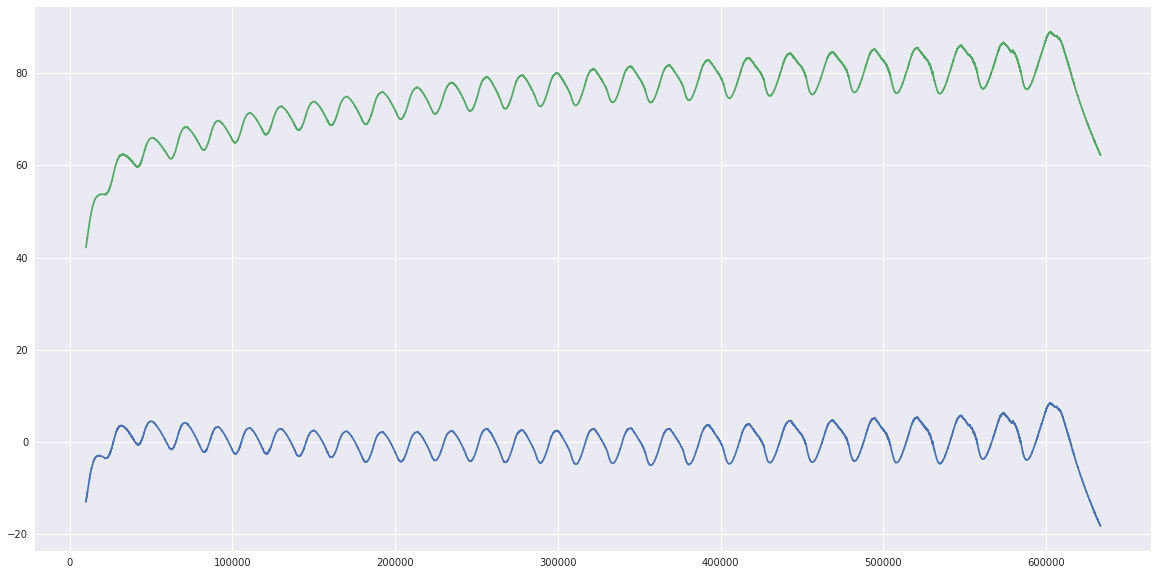

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(y-func(X, *pt))
ax.plot(temp.t)

In [25]:
np.mean(y-func(X, *pt))

3.738574064544086e-09

In [26]:
np.std(y-func(X, *pt))

3.5331308743155376

In [27]:
y_det = y-func(X, *pt)

### ARMA on `t`

In [28]:
from statsmodels.tsa.arima_model import ARMA

/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

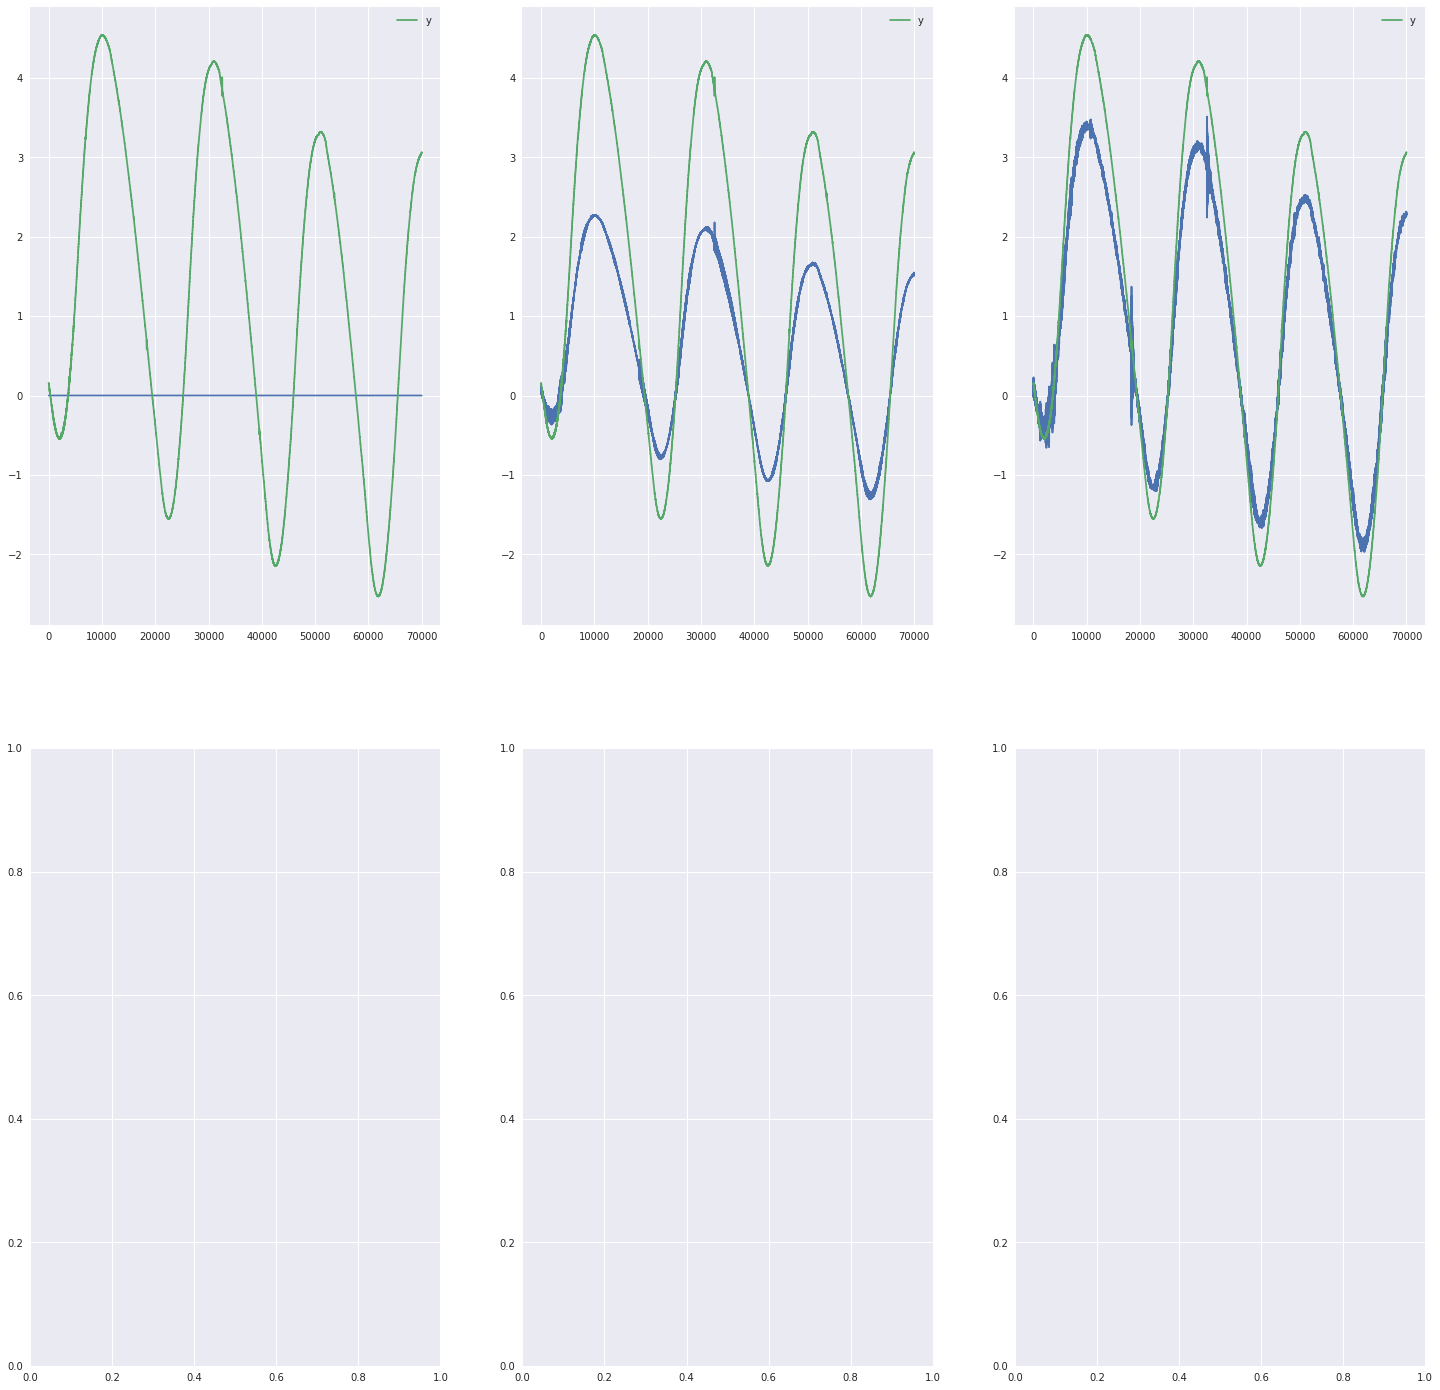

In [34]:
#endog = np.column_stack((X.values, y_det.values))
fig, axes = plt.subplots(2, 3, figsize=(25, 25))
for i in [0]:
    for j in [0,1,2]:
        mod = ARMA(y_det.values, order=(i,j))
        res = mod.fit()
        res.plot_predict(start=30000, end=100000, ax=axes.flat[5*i + j]) 
plt.show()

/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

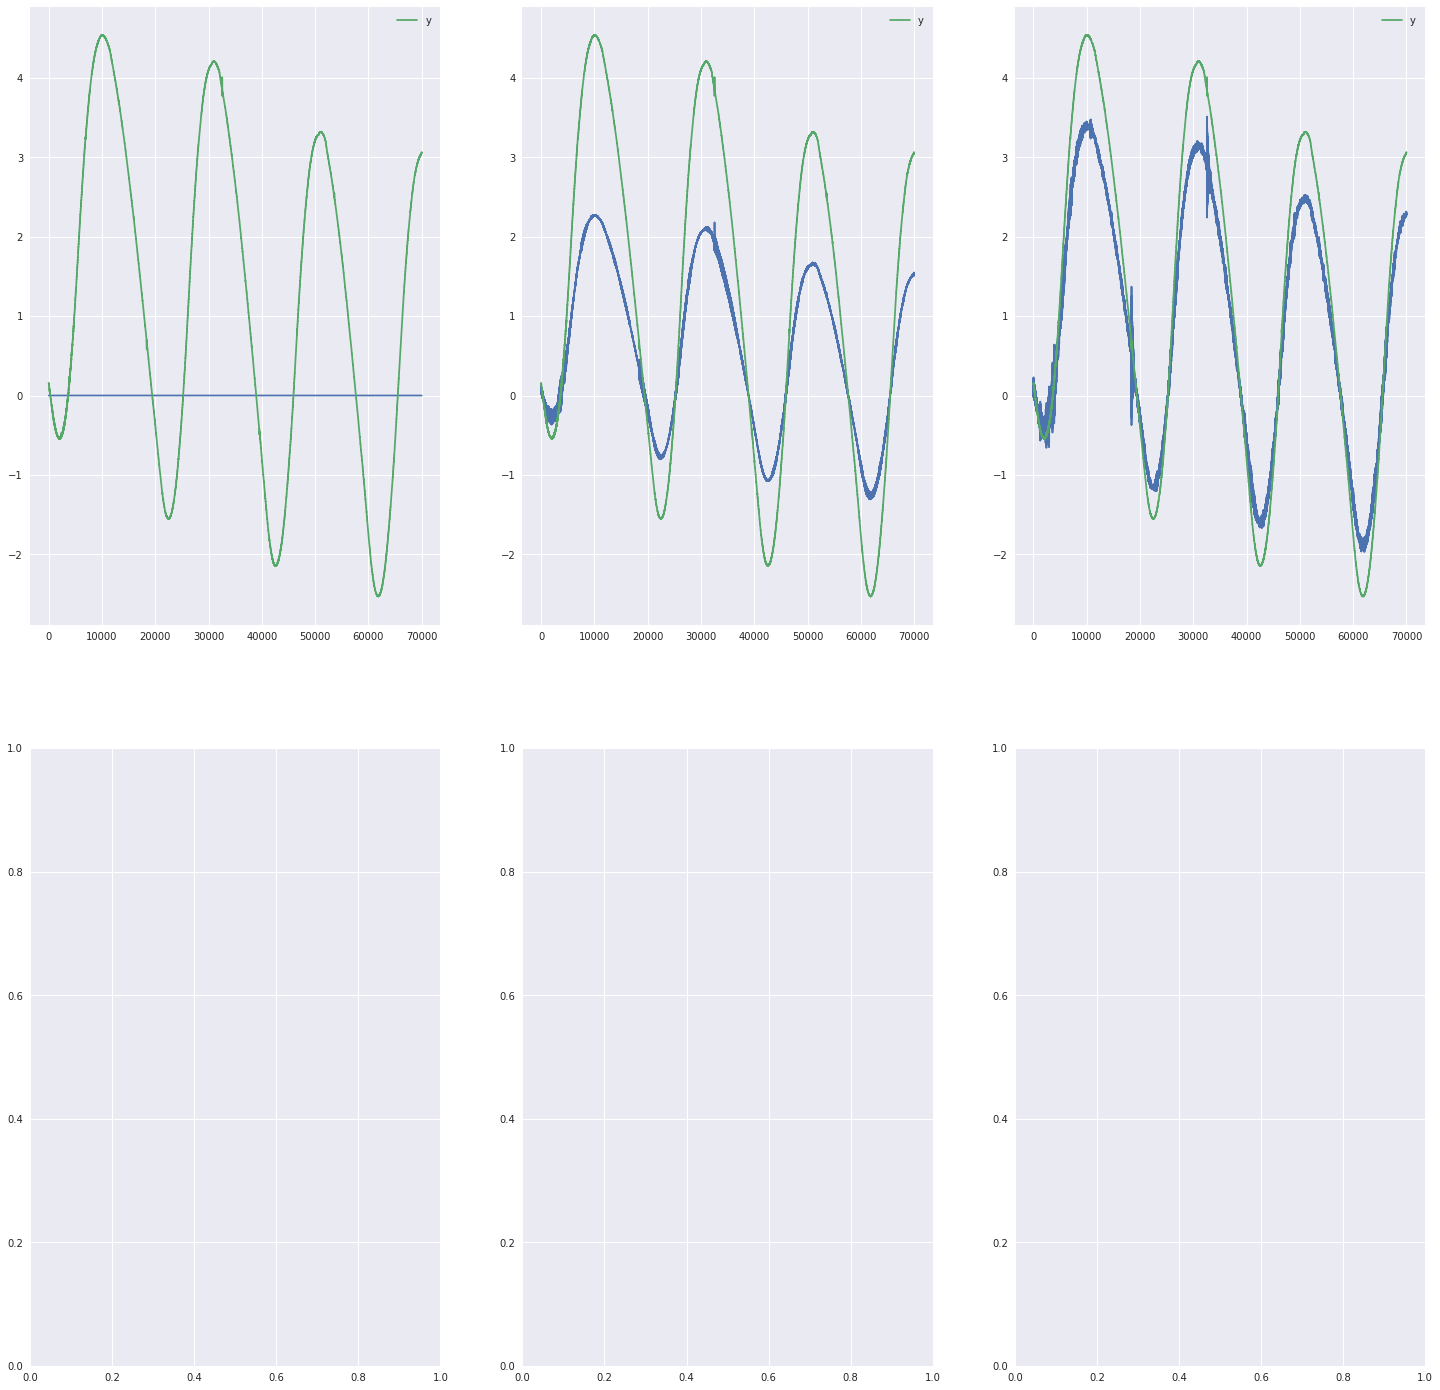

In [29]:
#endog = np.column_stack((X.values, y_det.values))
fig, axes = plt.subplots(2, 3, figsize=(25, 25))
for i in [0]:
    for j in [0,1,2]:
        mod = ARMA(y_det.values, order=(i,j))
        res = mod.fit()
        res.plot_predict(start=30000, end=100000, ax=axes.flat[5*i + j]) 
plt.show()

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1336: 

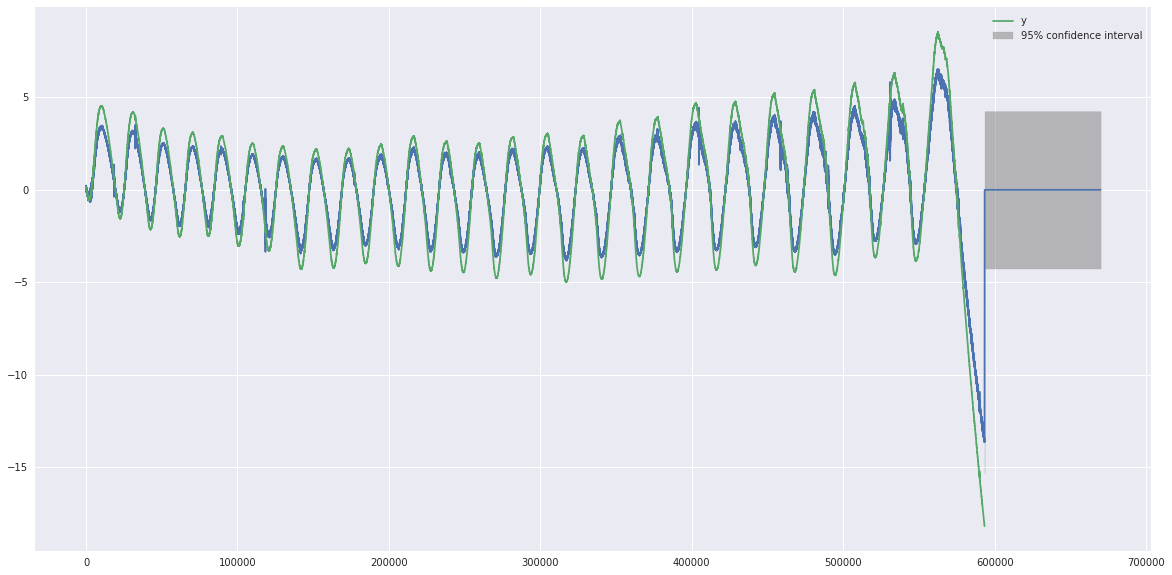

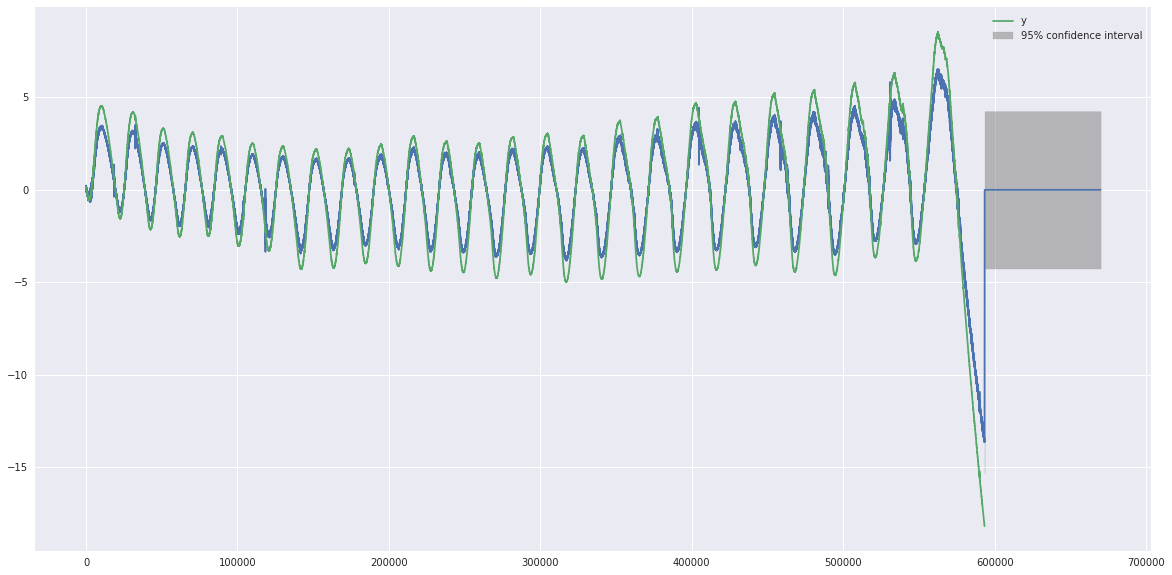

In [24]:
mod = ARMA(y_det.values, order=(0,2))
res = mod.fit()
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
res.plot_predict(start=30000, end=700000, ax=ax)

In [30]:
from sklearn.metrics import r2_score

In [31]:
res.predict(start=30000, end=700000)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


array([ 1.77081527e-02,  2.15116081e-01,  1.87112743e-02, ...,
       -4.87417326e-05, -4.87417326e-05, -4.87417326e-05])

In [32]:
mod.k_lags

3

In [33]:
mod.params

AttributeError: 'ARMA' object has no attribute 'params'

### exponential smoothing
$$ \hat{y_t} = \alpha y_t + (1-\alpha) \hat{y_{t-1}} $$
$$ a\rightarrow 0 \textrm{: smoother (weigh prev. observation more)} $$

In [13]:
def exp_smo(s, a):
    res = [s[0]]
    for i in range(1, len(s)):
        res.append(a*s[i] + (1-a)*res[i-1])
    return res

In [14]:
def plot_exp_smo(s, a, ax, alpha=1):
    ax.plot(exp_smo(s, a), alpha=a)

fig, ax = plt.subplots(1, 1, figsize=(30,10))
for a in [0.05, 0.3, 1.0]:
    plot_exp_smo(-df.f, a, ax, alpha=0.2)

In [15]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [16]:
def plot_autocorr(y, ax, lags=None):
    p_val = adfuller(y) # for fun
    plot_acf(y, lags=lags, ax=ax)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
plot_autocorr(df.f, ax, lags=70000)

### quick regression

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [284]:
def ts_train_test_split(X, y, test_size):
    test_i = int(len(X) * (1-test_size))
    X = X.dropna()
    y = y.dropna()
    X_train, X_test = X.iloc[:test_i], X.iloc[test_i:]
    y_train, y_test = y.iloc[:test_i], y.iloc[test_i:]
    X_train, X_test = X_train.values.reshape(-1,1), X_test.values.reshape(-1,1)
    y_train, y_test = y_train.values.reshape(-1,1), y_test.values.reshape(-1,1)
    return X_train, X_test, y_train, y_test

In [285]:
df.columns

Index(['f', 'msgtype', 'pwm', 'rc', 'rw', 't', 't0', 'timestamp'], dtype='object')

In [286]:
X = df['timestamp'].dropna()
y = df['f'].dropna()

In [287]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.3)

In [288]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [289]:
pred = lr.predict(X_test)

In [290]:
#fig, ax = plt.subplots(1, 1, figsize=(30,10))
#ax.plot(pred)
#ax.plot(y_test)

In [300]:
from sklearn.preprocessing import PolynomialFeatures

In [301]:
poly = PolynomialFeatures(3)
ma = plot_ma(-df.f, 500, ax, 1, get_ma=True)

In [303]:
X, y = df[['timestamp', 'f']], df['f']
poly.fit_transform(X)
X = X.timestamp
X_train, X_test, y_train, y_test = ts_train_test_split(X, ma, test_size=0.1)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

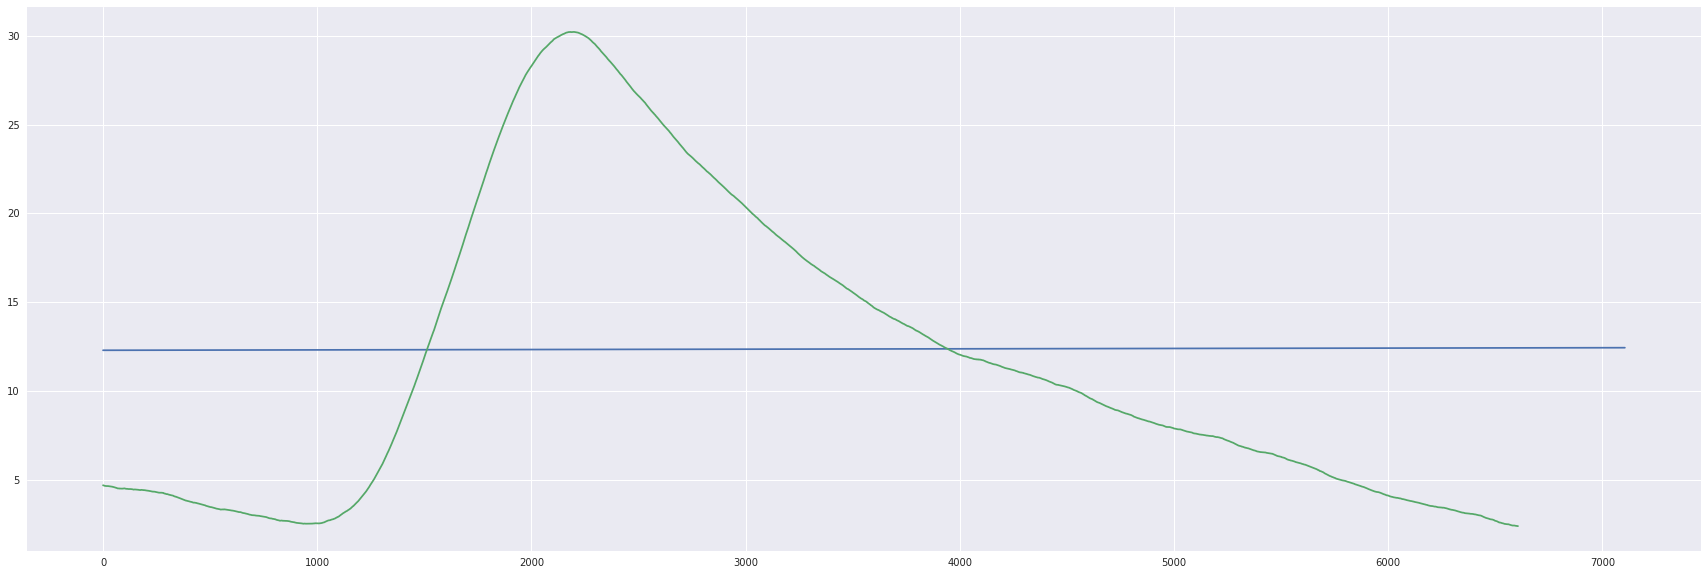

In [305]:
pred = lr.predict(X_test)
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.plot(pred)
ax.plot(y_test)

### ARMA

In [311]:
from statsmodels.tsa.arima_model import ARMA

In [314]:
Xf = df.f
Xf.index = pd.to_datetime(df.timestamp, unit='ms')

In [316]:
model = ARMA(Xf, order=(1,0))
result = model.fit()

/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nwchen/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


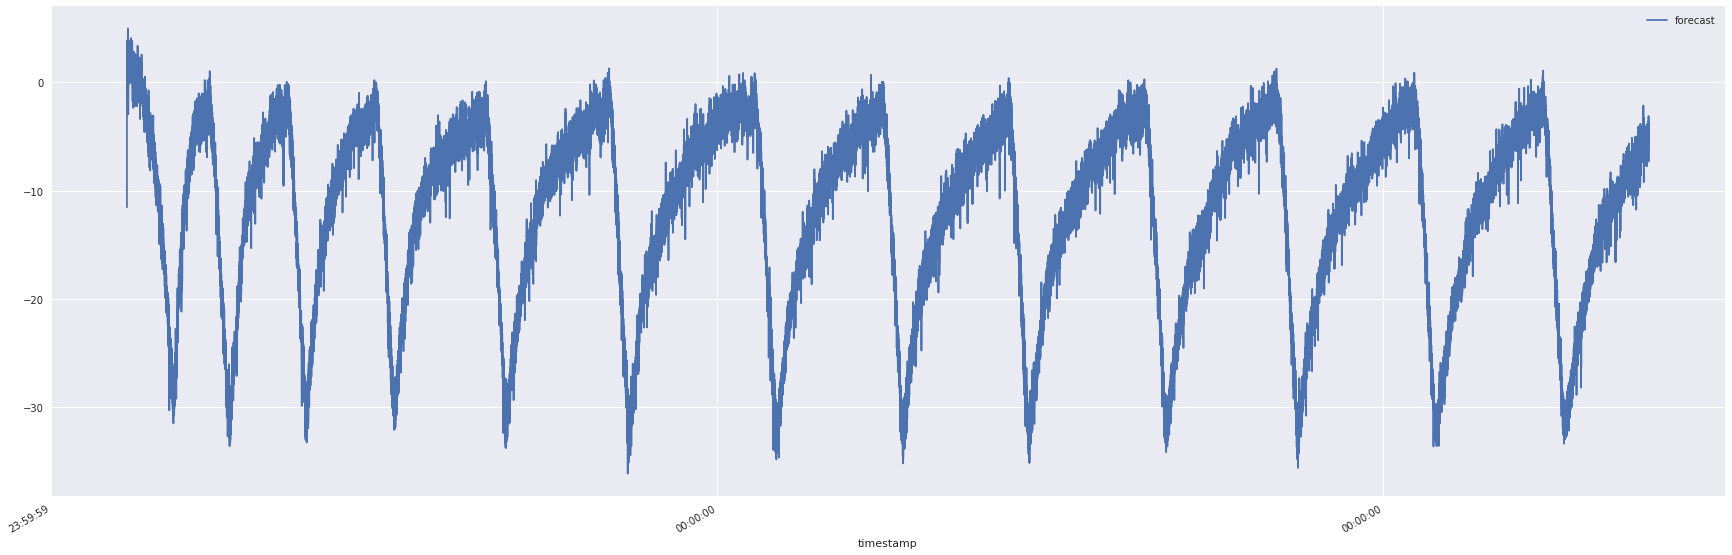

In [324]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
result.plot_predict(start=0, end=70000, ax=ax, plot_insample=False)
plt.show()

In [ ]:
Xma = pd.DataFrame(data=ma)
Xma.index = pd.to_datetime(df.timestamp, unit='ms')
Xma = Xma.replace([np.inf, -np.inf], np.nan).dropna()
model = ARMA(Xma, order=(1,0))
result = model.fit()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
result.plot_predict(start=0, end=70000, ax=ax, plot_insample=False)
ax.plot(-df.f, alpha=0.3)
plt.show()

### RMSE
$$ \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i - \hat{y_i})^2} $$

In [443]:
rmse = lambda y, yhat: np.sqrt(((y-yhat)**2).mean())
mae = lambda y, yhat: np.abs(y-yhat).mean()

In [444]:
pred = result.predict(start=0, end=70000)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [375]:
rmse(pred.f, Xf.f)

28.448979096177236

In [378]:
mae(pred.f, Xf.f)

23.452899800206044

In [65]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.show()
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

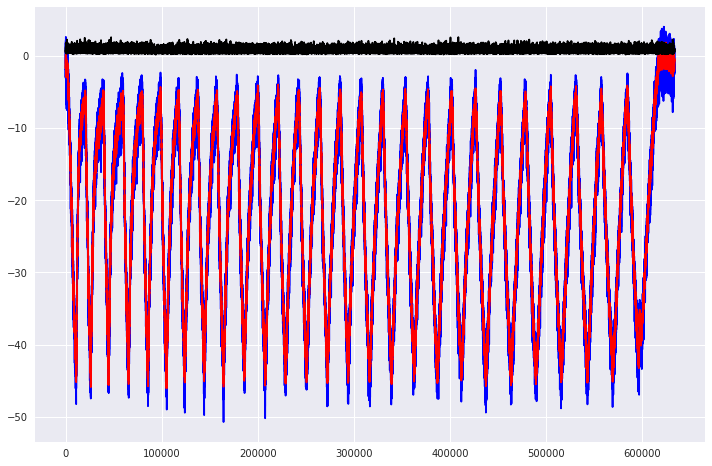

In [ ]:
test_stationarity(df.f)

# X=PWM

In [45]:
X = df.pwm
X[X.notnull()] = 1
X[X.isnull()] = 0

In [ ]:
#endog = np.column_stack((X.values, y_det.values))
fig, axes = plt.subplots(2, 3, figsize=(25, 25))
for i in [0]:
    for j in [0,1,2]:
        mod = ARMA(y_det.values, order=(i,j))
        res = mod.fit()
        res.plot_predict(start=30000, end=100000, ax=axes.flat[5*i + j]) 
plt.show()